In [1]:
# for compatible with python 3
from __future__ import print_function
import os
# os.environ["KERAS_BACKEND"] = "theano"
import numpy as np
from utils.data import read_stock_history, index_to_date, date_to_index, normalize
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# Seaborn, useful for graphics
import seaborn as sns

# Import Bokeh modules for interactive plotting
import bokeh.io
#import bokeh.mpl
import bokeh.plotting

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables SVG graphics inline.  There is a bug, so uncomment if it works.
# %config InlineBackend.figure_formats = {'svg',}

# This enables high resolution PNGs. SVG is preferred, but has problems
# rendering vertical and horizontal lines
%config InlineBackend.figure_formats = {'png', 'retina'}
matplotlib.rcParams['figure.figsize'] = (10, 6)
plt.rc('legend', fontsize=20)
# JB's favorite Seaborn settings for notebooks
rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style('darkgrid', rc=rc)

# Set up Bokeh for inline viewing
bokeh.io.output_notebook()

Loading BokehJS ...

In [3]:
from model.ddpg.actor import ActorNetwork
from model.ddpg.critic import CriticNetwork
from model.ddpg.ddpg import DDPG
from model.ddpg.ornstein_uhlenbeck import OrnsteinUhlenbeckActionNoise

import numpy as np
import tflearn
import tensorflow as tf

from stock_trading import StockActor, StockCritic, obs_normalizer, get_model_path, get_result_path, \
                          test_model, get_variable_scope, test_model_multiple
    
from model.supervised.lstm import StockLSTM
from model.supervised.cnn import StockCNN

Instructions for updating:
Colocations handled automatically by placer.


Using TensorFlow backend.


In [4]:
import random
from utils.data import create_target_dataset

In [7]:
# history, abbreviation = read_stock_history('utils/datasets/test.h5')

# # create new dataset with 100 random stocks from entire dataset
# random.seed(30)
# new_list = random.sample(abbreviation,100)

# create_target_dataset(new_list,filepath='utils/datasets/stocks_history_target3.h5')

In [8]:
# dataset for 100 stocks by splitting timestamp
history, abbreviation = read_stock_history(filepath='utils/datasets/test.h5')
history = history[:, :, :4]

# 100 stocks are all involved. We choose first 2/3 years as training data
num_training_time = 2000
target_stocks = abbreviation
target_history = np.empty(shape=(len(target_stocks), num_training_time, history.shape[2]))

for i, stock in enumerate(target_stocks):
    target_history[i] = history[abbreviation.index(stock), :num_training_time, :]

# and last 1/3 years as testing data.
testing_stocks = abbreviation
testing_history = np.empty(shape=(len(testing_stocks), history.shape[1] - num_training_time, 
                               history.shape[2]))
for i, stock in enumerate(testing_stocks):
    testing_history[i] = history[abbreviation.index(stock), num_training_time:, :]

In [15]:
data = history[:, (4 - 3):(4 + 2000 + 1), :4]
data.shape

(100, 2004, 4)

In [16]:
data[:, 4:4 + 3, :].shape

(100, 3, 4)

In [5]:
# common settings
batch_size = 64
action_bound = 1.
tau = 1e-3

In [6]:
models = []
model_names = []
window_length_lst = [3]
predictor_type_lst = ['cnn']
use_batch_norm = True

In [7]:
nb_classes = len(target_stocks) + 1
print(target_history.shape)
print(testing_history.shape)

(100, 2000, 4)
(100, 1000, 4)


In [8]:
from environment.portfolio import PortfolioEnv, MultiActionPortfolioEnv
env = PortfolioEnv(target_history, target_stocks)

Start date: 2021-09-22


In [9]:
# instantiate environment, 100 stocks, with trading cost, window_length 3, start_date sample each time
# load weights = FALSE
for window_length in window_length_lst:
    for predictor_type in predictor_type_lst:
        name = 'DDPG_window_{}_predictor_{}'.format(window_length, predictor_type)
        model_names.append(name)
        tf.reset_default_graph()
        sess = tf.Session()
        tflearn.config.init_training_mode()
        action_dim = [nb_classes]
        state_dim = [nb_classes, window_length]
        variable_scope = get_variable_scope(window_length, predictor_type, use_batch_norm)
        with tf.variable_scope(variable_scope):
            actor = StockActor(sess, state_dim, action_dim, action_bound, 1e-4, tau, batch_size, predictor_type, 
                               use_batch_norm)
            critic = StockCritic(sess=sess, state_dim=state_dim, action_dim=action_dim, tau=1e-3,
                                 learning_rate=1e-3, num_actor_vars=actor.get_num_trainable_vars(), 
                                 predictor_type=predictor_type, use_batch_norm=use_batch_norm)
            actor_noise = OrnsteinUhlenbeckActionNoise(mu=np.zeros(action_dim))

            model_save_path = get_model_path(window_length, predictor_type, use_batch_norm)
            summary_path = get_result_path(window_length, predictor_type, use_batch_norm)

            ddpg_model = DDPG(env, sess, actor, critic, actor_noise, obs_normalizer=obs_normalizer,
                              config_file='config/stock.json', model_save_path=model_save_path,
                              summary_path=summary_path)
            ddpg_model.initialize(load_weights=False, verbose=False)
            models.append(ddpg_model)

Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Build model from scratch


In [10]:
ddpg_model.train()

Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'NoneType' object has no attribute 'name'
Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'NoneType' object has no attribute 'name'
Episode: 0, Reward: 0.25, Qmax: 0.0656


KeyboardInterrupt: 

In [16]:
# instantiate environment, 100 stocks, with trading cost, window_length 3, start_date sample each time
# load weights = FALSE
for window_length in window_length_lst:
    for predictor_type in predictor_type_lst:
        name = 'DDPG_window_{}_predictor_{}'.format(window_length, predictor_type)
        model_names.append(name)
        tf.reset_default_graph()
        sess = tf.Session()
        tflearn.config.init_training_mode()
        action_dim = [nb_classes]
        state_dim = [nb_classes, window_length]
        variable_scope = get_variable_scope(window_length, predictor_type, use_batch_norm)
        with tf.variable_scope(variable_scope):
            actor = StockActor(sess, state_dim, action_dim, action_bound, 1e-4, tau, batch_size, predictor_type, 
                               use_batch_norm)
            critic = StockCritic(sess=sess, state_dim=state_dim, action_dim=action_dim, tau=1e-3,
                                 learning_rate=1e-3, num_actor_vars=actor.get_num_trainable_vars(), 
                                 predictor_type=predictor_type, use_batch_norm=use_batch_norm)
            actor_noise = OrnsteinUhlenbeckActionNoise(mu=np.zeros(action_dim))

            model_save_path = get_model_path(window_length, predictor_type, use_batch_norm)
            summary_path = get_result_path(window_length, predictor_type, use_batch_norm)

            ddpg_model = DDPG(None, sess, actor, critic, actor_noise, obs_normalizer=obs_normalizer,
                              config_file='config/stock.json', model_save_path=model_save_path,
                              summary_path=summary_path)
            ddpg_model.initialize(load_weights=True, verbose=False)
            models.append(ddpg_model)

Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from weights/stock/cnn/window_3/batch_norm/checkpoint.ckpt


In [30]:
env = MultiActionPortfolioEnv(target_history, target_stocks, model_names[:1], steps=1000, 
                              sample_start_date='2012-10-30')

Start date: 2012-10-30


<Figure size 720x432 with 0 Axes>

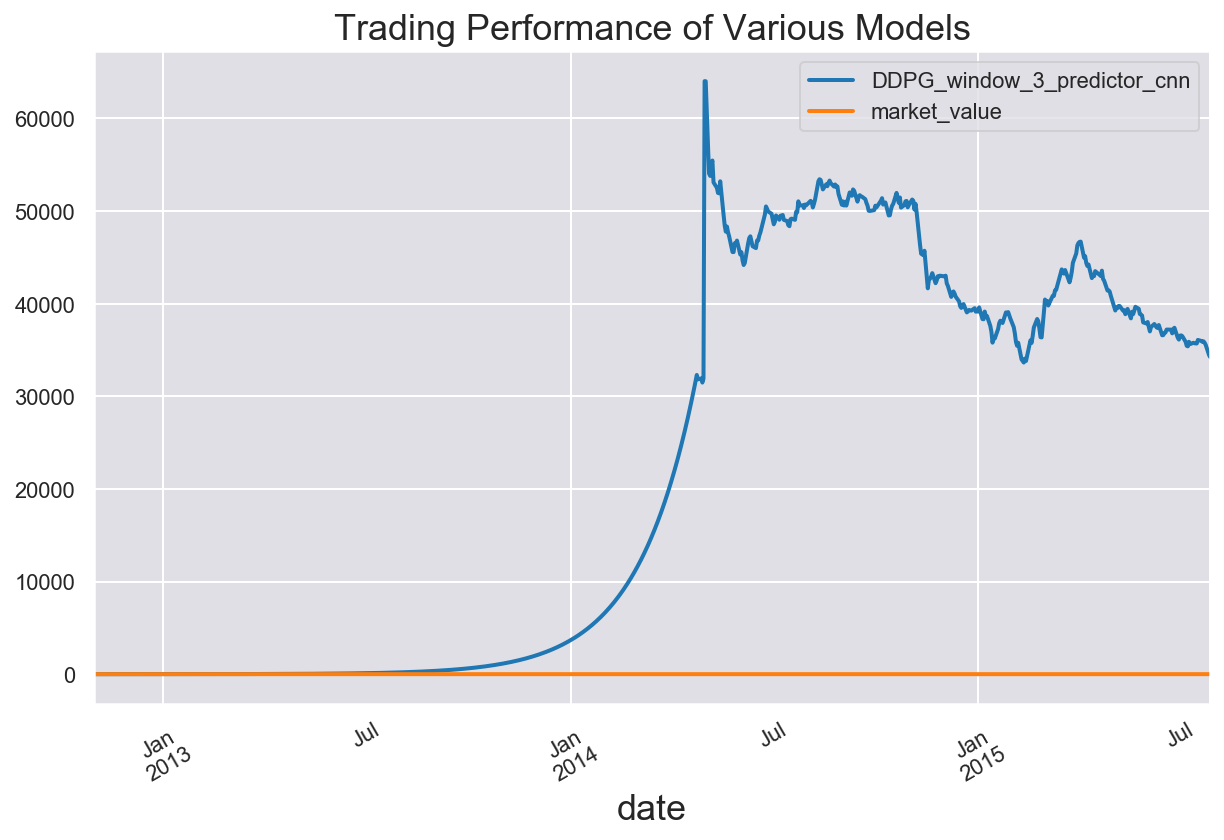

In [31]:
# results on training data
test_model_multiple(env, models[:1])

In [32]:
env = MultiActionPortfolioEnv(testing_history, testing_stocks, model_names[:1], steps=650, start_idx=num_training_time, 
                   sample_start_date='2015-10-30')

Start date: 2012-10-30


<Figure size 720x432 with 0 Axes>

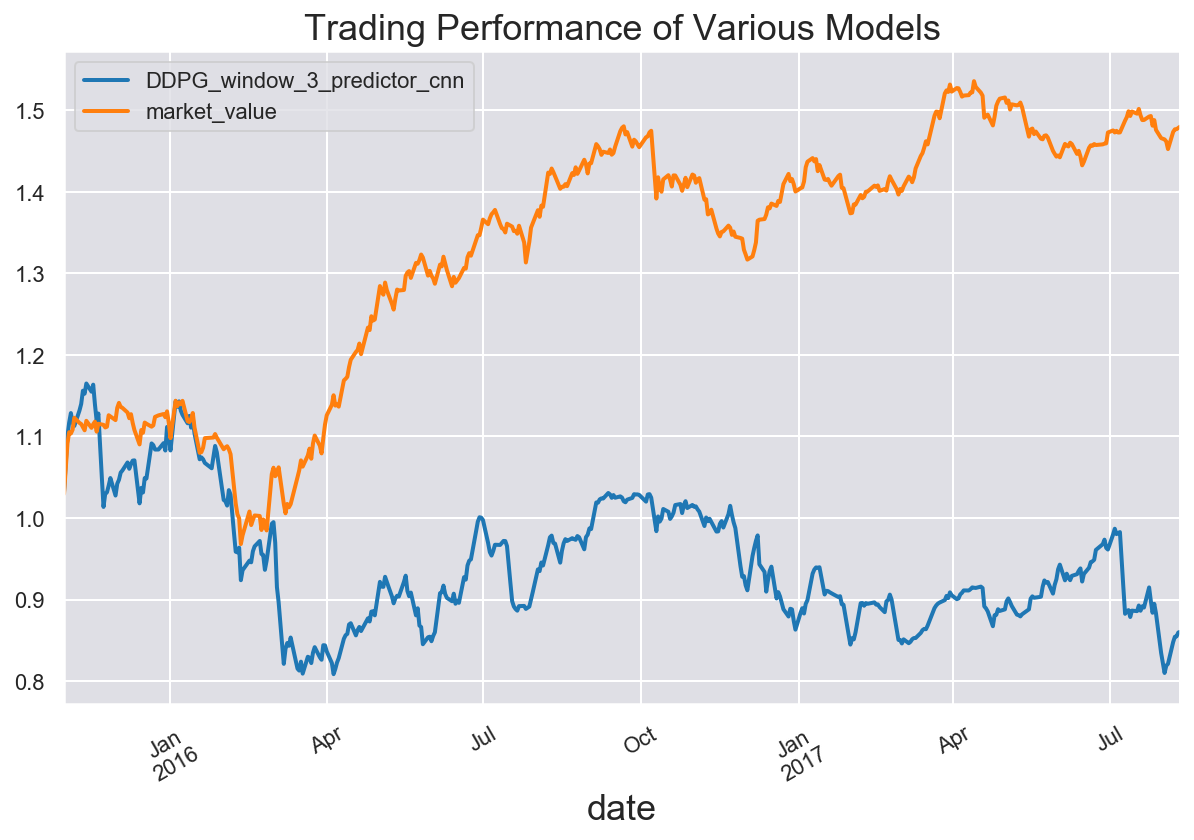

In [33]:
# results on test data
test_model_multiple(env, models[:1])

In [ ]:
# try training with more episodes
# try training data with different stocks
# try different window lengths
# try different predictors